# Desafio de Programação 3A: Classificação Multiclasse e Redes Neurais


## Identificação:

**Nome:** Rodrigo Reis

**Matrícula:** 222026546

## Introdução

Neste exercício, nós implementaremos a regressão logística one-vs-all (um contra todos) e redes neurais para reconhecer dígitos manuscritos.

Todas as informações necessárias para resolver esta tarefa estão neste ambiente, e todas as partes do código devem ser implementadas ao longo deste notebook.

Antes de iniciarmos o exercício, nós precisamos que algumas bibliotecas já estejam disponíveis. São elas:

- Numpy: (http://www.numpy.org/) para todas as operações matriciais;
- Matplotlib: (https://matplotlib.org/) para a plotagem dos gráficos;
- Scipy(https://docs.scipy.org/doc/scipy/reference/) que contém funções e ferramentas de cálculo numérico e científico.

In [1]:
#allows the drive to be accessed
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [38]:
import sys

!cat '/content/drive/MyDrive/TopEng/DP3A/utils.py'
sys.path.append('/content/drive/MyDrive/TopEng/DP3A')

import sys
import numpy as np
from matplotlib import pyplot


def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
               

In [39]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Classificação Multiclasse

Para este exercício, nós utilizaremos regressão logística e redes neurais para identificar dígitos numéricos manuscritos (de 0 a 9). Reconhecimento automático de dígitos manuscritos é largamente utilizado atualmente. Este exercício mostrará como os métodos aprendidos podem ser usados para tarefas de classificação.

Na primeira parte do exercício, nós iremos estender a implementação de regressão logística que fizemos no Desafio de Programação 2. Como complemento, nós aplicaremos a classificação one-vs-all.

### 1.1 Dataset

Nós disponibilizamos o dataset em `ex3data1.mat` contendo 5 mil exemplos de treinamento com dígitos manuscritos (os exemplos foram retirados do dataset [MNIST](http://yann.lecun.com/exdb/mnist)). Utilizaremos a função `loadmat` com o módulo do `scipy.io` para abrir o documento no formato `.mat`, o que nos retornará um dicionário python.

Existem 5000 exemplos de treinamento em `ex3data1.mat`, em que cada exemplo é uma imagem em escala de cinza de 20x20 pixels. Cada pixel é representado por um número (uma variável do tipo float) indicando a intensidade naquele local. A rede de 20x20 pixels é convertida em um vetor de comprimento igual a 400. Cada um desses exemplos de treinamento é iniciado em uma linha da matriz `
X`. Isto faz com que a matriz `X` tenha dimensão de 5000x400, em que cada linha é um exemplo de treinamento com a imagem do dígito numérico manuscrito.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

A segunda parte dos dados de treinamento é o vetor `y` de dimensão 5000x1 e contém as labels (o dígito correto presente em cada imagem). Nós iniciaremos o exercício carregando o dataset. Para isso, execute a célula abaixo.

In [5]:
# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Utilidades-TP3/Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

### 1.2 Visualizando os dados

Nós iniciaremos visualizando uma parte do nosso dataset de treinamento. Na próxima célula, o código selecionará randomicamente 100 linhas de `X` que servirão de entrada da função `displayData`. Esta função mapeia cada linha em uma imagem de 20x20 pixels na escala de cinza e mostra as imagens juntas. Nós já fornecemos a função `displayData` no arquivo `utils.py`. É recomendável que você examine o código para ver como ele funciona.

Execute a próxima célula para visualizar os dados.

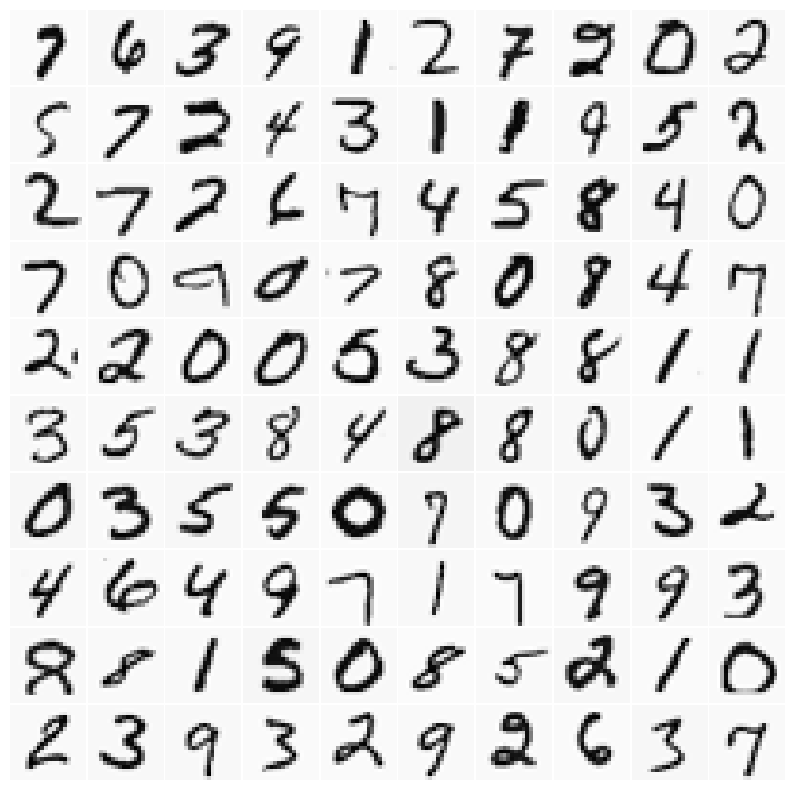

In [6]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.3 Vetorização da Regressão Logística

Nós iremos utilizar o modelo de regressão logística one-vs-all para construir um classificador multiclasses. Como existem 10 classes, nós precisaremos treinar separadamente 10 classificadores com regressão logística. Para tornar esse treinamento eficiente, é importante se certificar que o seu código está vetorizado da forma correta. Nesta seção, você irá implementar a versão vetorizada da regressão logística que não aplica nenhum loop `for`. Você pode utilizar o seu código do último Desafio de programação para iniciar este exercício.

Para testar esta regressão logística vetorizada, nós usaremos dados personalizados, conforme definido na célula a seguir.

In [7]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

<a id="section1"></a>
#### 1.3.1 Vetorização da função de custo

Nós iremos iniciar escrevendo a versão vetorizada da função de custo. Recorde-se que na regressão logística (não regularizada), a função de custo é

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

Para calcular cada elemento da somatória, nós iremos calcular $h_\theta(x^{(i)})$ para todos os exemplos $i$, em que $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$, em que $g(z) = \frac{1}{1+e^{-z}}$ é a função sigmoid. Isto faz com que nós possamos calcular isto de forma mais rápida para todos os nossos exemplos utilizando multiplicação entre matrizes. Para isso, definiremos $X$ e $\theta$ como

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{e} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Assim, calculando o produto entre as matrizes $X\theta$, nós teremos:

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

Na última equação, nós utilizamos o fato de que $a^Tb = b^Ta$ se $a$ e $b$ são vetores. Isto permite que nós calculemos o produto $\theta^T x^{(i)}$ para todos os nossos exemplos $i$ em apenas uma linha de código.

#### 1.3.2 Vetorização do gradiente

Recorde-se que o gradiente do custo na regressão logística (não regularizada) é um vetor em que o elemento $j^{th}$ é definido como

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

Para vetorizar esta operação no dataset, nós iniciaremos escrevendo todas as derivadas parciais explícitas para todo $\theta_j$,

$$
\begin{align*}
\begin{bmatrix}
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

em que

$$  h_\theta(x) - y =
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)}
\end{bmatrix} $$

Note que $x^{(i)}$ é um vetor, enquanto $h_\theta\left(x^{(i)}\right) - y^{(i)}$ é um escalar (um número). Para entender o último passo desta derivação, tome $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ e observe que:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix}
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & |
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

em que os valores $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

A expressão acima nos permite calcular todas as derivadas parciais sem utilizar nenhum loop. Se você se sente confortável com álgebra linear, nós os encorajamos a trabalhar com as multiplicações matriciais acima para se convencer que a versão vetorizada executa os mesmos cálculos.

A sua tarefa é escrever a função de custo não regularizada `lrCostFunction` que retorne a função de custo $J(\theta)$ e os seus gradientes $\frac{\partial J}{\partial \theta}$. Recomendamos que você faça a implementação utilizando a estratégia apresentada acima para calcular $\theta^T x^{(i)}$. Recomendamos também que você utilize a vetorização para o restante da função de custo. A versão totalmente vetorizada de `lrCostFunction` não deve conter nenhum loop.

A correta implementação desta função lhe agregará **30 pontos** dentro da pontuação total deste desafio de programação.

In [8]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.

    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is
        the number of features including any intercept.

    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).

    y : array_like
        The data labels. A vector with shape (m, ).

    lambda_ : float
        The regularization parameter.

    Returns
    -------
    J : float
        The computed value for the regularized cost function.

    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.

    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta

    Hint 1
    ------
    The computation of the cost function and gradients can be efficiently
    vectorized. For example, consider the computation

        sigmoid(X * theta)

    Each row of the resulting matrix will contain the value of the prediction
    for that example. You can make use of this to vectorize the cost function
    and gradient computations.

    Hint 2
    ------
    When computing the gradient of the regularized cost function, there are
    many possible vectorized solutions, but one solution looks like:

        grad = (unregularized gradient for logistic regression)
        temp = theta
        temp[0] = 0   # because we don't add anything for j = 0
        grad = grad + YOUR_CODE_HERE (using the temp variable)

    Hint 3
    ------
    We have provided the implementatation of the sigmoid function within
    the file `utils.py`. At the start of the notebook, we imported this file
    as a module. Thus to access the sigmoid function within that file, you can
    do the following: `utils.sigmoid(z)`.

    """
    #Initialize some useful values
    m = y.size

    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)

    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    h = 1 / (1 + np.exp(-X.dot(theta)))
    cost = (-1 / m) * (y.dot(np.log(h)) + (1 - y).dot(np.log(1 - h)))

    regularization = (lambda_ / (2 * m)) * np.sum(theta[1:]**2)

    J = cost + regularization

    grad = (1 / m) * X.T.dot(h - y)

    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]

    # =============================================================
    return J, grad

#### 1.3.3 Vetorização da regressão logística regularizada

Após a implementação da regressão logística, nós adicionaremos agora a regularização da função de custo. Repare que para a regressão logística regularizada, a função de custo é definida como

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note que você NÃO deve regularizar $\theta_0$, que é usado como o termo bias (viés). De forma análoga, as derivadas parciais do custo da regressão logística regularizada para $\theta_j$ são definidas como

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

Agora, modifique o seu código de lrCostFunction na célula anterior levando em conta a regularização. Mais uma vez, você não deve implementar nenhum loop no seu código.

<div class="alert alert-box alert-warning">
**Dica de python/numpy:** Na implementação da regressão logística regularizada, você provavelmente vai desejar somar e atualizar apenas alguns elementos de $\theta$. Em `numpy`, você pode utilizar os índices para acessar e atualizar somente certos elementos. Por exemplo, A[:, 3:5] = B[:, 1:3] irá modificar as colunas com índice 3 ao 5 de A com as colunas de índice de 1 a 3 de B.
</div>

Uma vez finalizada a sua implementação, você pode chamar a função `lrCostFunction` para testar a sua solução ao executar a próxima célula:

In [9]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Custo         : {:.6f}'.format(J))
print('Custo esperado: 2.534819')
print('-----------------------')
print('Gradiente:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Gradiente esperado:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Custo         : 2.534819
Custo esperado: 2.534819
-----------------------
Gradiente:
 [0.146561, -0.548558, 0.724722, 1.398003]
Gradiente esperado:
 [0.146561, -0.548558, 0.724722, 1.398003]


<a id="section2"></a>
### 1.4 Classificação one-vs-all

Nesta parte do nosso exercício, você irá implementar a classificação one-vs-all para treinar múltiplos classificadores de regressão logística, um para cada classe $K$ do nosso dataset. Em um dataset de dígitos numéricos manuscritos, $K = 10$, mas o seu código deve funcionar para qualquer valor de $K$.

Você deve completar o código da função `oneVsAll` abaixo para treinar um classificador por classe. Em particular, o seu código deve retornar todos os parâmetros do seu classificador em uma matriz $\theta \in \mathbb{R}^{K \times (N +1)}$, em que cada linha de $\theta$ corresponde aos parâmetros treinados para a regressão logística para uma classe. Uma possibilidade é utilizar um “for”-loop de $0$ a $K-1$, treinando cada classificador de forma independente.

Note que o argumento `y` desta função é um vetor de labels de 0 a 9. Quando treinamos o classificador para $k \in \{0, ..., K-1\}$ classes , nós queremos um vetor de dimensão K de labels $y$, em que $y_j \in 0, 1$ indica se a label pertence a essa classe $j^{th}$ $(y_j = 1)$, ou não $(y_j = 0)$.
Você pode achar matrizes lógicas úteis para esta tarefa.

Além disso, nós utilizaremos a função `optimize.minimize` da biblioteca Scipy neste exercício.

A correta implementação desta função lhe agregará **30 pontos** dentro da pontuação total deste desafio de programação.
<a id="oneVsAll"></a>

In [12]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of
        data points, and n is the number of features. Note that we
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.

    Instructions
    ------------
    You should complete the following code to train `num_labels`
    logistic regression classifiers with regularization parameter `lambda_`.

    Hint
    ----
    You can use y == c to obtain a vector of 1's and 0's that tell you
    whether the ground truth is true/false for this class.

    Note
    ----
    For this assignment, we recommend using `scipy.optimize.minimize(method='CG')`
    to optimize the cost function. It is okay to use a for-loop
    (`for c in range(num_labels):`) to loop over the different classes.

    Example Code
    ------------

        # Set Initial theta
        initial_theta = np.zeros(n + 1)

        # Set options for minimize
        options = {'maxiter': 50}

        # Run minimize to obtain the optimal theta. This function will
        # return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
    """
    # Some useful variables
    m, n = X.shape

    # You need to return the following variables correctly
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)

        options = {'maxiter': 50}

        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        all_theta[c] = res.x

    # ============================================================
    return all_theta

Após completar o código de `oneVsAll`, podemos executar a próxima célula para utilizar a nossa implementação para treinar um classificador multiclasse.

In [13]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

<a id="section3"></a>
#### 1.4.1 Previsões One-vs-all

Após treinar o seu classificador one-vs-all, você poderá usá-lo para prever qual é o dígito manuscrito na imagem. Para cada entrada, você deve calcular a probabilidade de que o dígito contido na imagem pertença a cada classe. A nossa função de previsões one-vs-all irá selecionar a classe cuja probabilidade seja a maior e retornará a label (0, 1, ..., K-1) como previsão para o nosso exemplo de entrada. Você deve completar a função `predictOneVsAll` para utilizar o classificador one-vs-all para fazer previsões.

A correta implementação desta função lhe agregará **10 pontos** dentro da pontuação total deste desafio de programação.

<a id="predictOneVsAll"></a>

In [16]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X.
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the
    i-th class. You should set p to a vector of values from 0..K-1
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .

    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).

    Instructions
    ------------
    Complete the following code to make predictions using your learned logistic
    regression parameters (one-vs-all). You should set p to a vector of predictions
    (from 0 to num_labels-1).

    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.
    """
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    probabilities = np.dot(X, all_theta.T)
    p = np.argmax(probabilities, axis=1)
    # ============================================================
    return p

Uma vez que você finalizar, chame a função `predictOneVsAll` utilizando o valor de $\theta$ treinado. Você deve ver a acurácia de treino por volta de 95.1%.

In [17]:
pred = predictOneVsAll(all_theta, X)
print('Acurácia de treinamento: {:.2f}%'.format(np.mean(pred == y) * 100))

Acurácia de treinamento: 95.10%


## 2 Redes Neurais

Na parte anterior do exercício, você implementou a regressão logística multiclasse para reconhecer dígitos manuscritos. Entretanto, regressão logística não consegue formar hipóteses mais complexas já que consiste de apenas um classificador linear. Nós até poderíamos adicionar mais features à regressão logística, mas isso se tornaria o treinamento muito custoso.

Nesta parte, você irá implementar uma rede neural para reconhecer os dígitos manuscritos utilizando o mesmo dataset de treinamento. A rede neural será capaz de representar modelos mais complexos com hipóteses não lineares. Para esta semana, nós iremos utilizar os parâmetros de uma rede neural já treinada. O nosso objetivo é implementar o algoritmo de propagação direta (feedforward) para usar nossos parâmetros para fazer previsões. No exercício da próxima semana, você irá escrever o algoritmo de retropropagação (backpropagation) para aprender os parâmetros de redes neurais.

Nós iniciaremos recarregando e visualizando o dataset que contém os dígitos manuscritos MNIST (isto é o mesmo que nós fizemos na primeira parte do exercício, nós recarregamos apenas para ter certeza de que as variáveis não foram modificadas).

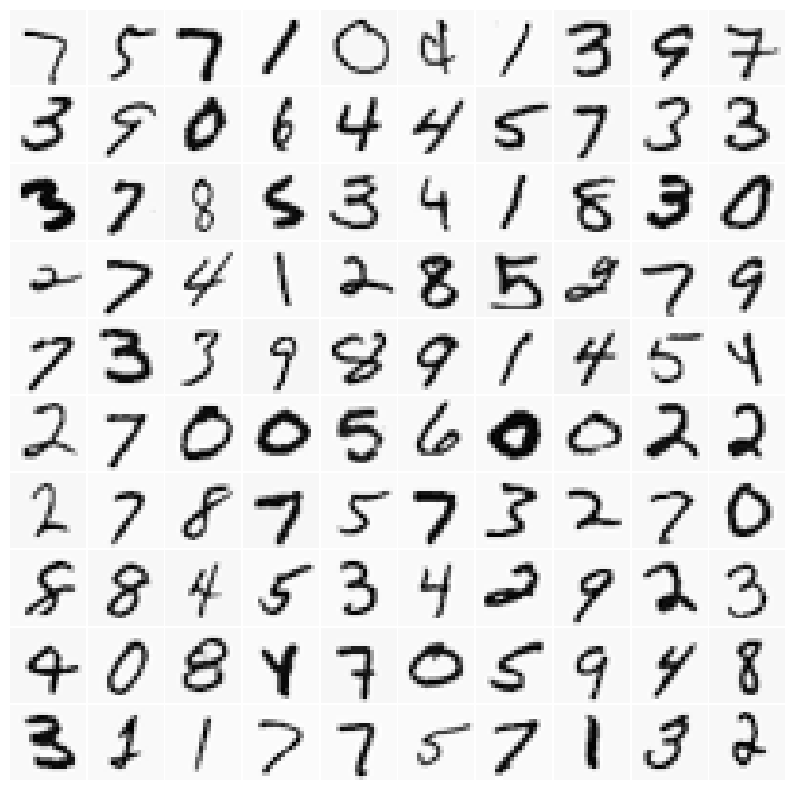

In [18]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Utilidades-TP3/Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)


### 2.1 Representação do modelo

Nosso modelo de rede neural está mostrado na figura seguinte.

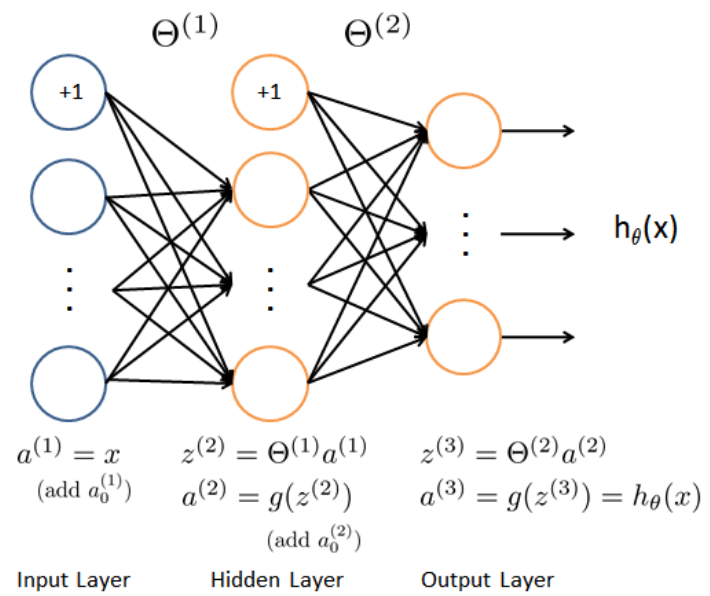

Este modelo possui 3 camadas: Uma camada de entrada (input layer), uma camada oculta (hidden layer) e uma camada de saída (output layer). Relembre que as suas entradas são valores dos pixels com a imagem do dígito. Sabendo que as imagens são do tamanho 20x20, isto resultará em uma camada de entrada de 400 unidades (excluindo uma unidade extra de bias que sempre gera +1). Como dito anteriormente, os dados de treinamento serão carregados nas variáveis X e y.

Você recebeu um conjunto de parâmetros da rede ($\Theta^{(1)}$, $\Theta^{(2)}$) já treinados por nós. Isto está guardado no arquivo `ex3weights.mat`. A próxima célula carrega os parâmetros em `Theta1` e `Theta2`. Os parâmetros possuem dimensões que estão arranjados para uma rede neural com 25 unidades na segunda camada e 10 unidades na camada de saída (correspondente às 10 classes).

In [19]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary
weights = loadmat(os.path.join('Utilidades-TP3/Data', 'ex3weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing,
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

<a id="section4"></a>
### 2.2 Propagação Feedforward e Previsão

Agora nós iremos implementar a propagação direta para a rede neural. Você deverá completar o código da função `predict` para retornar as previsões da rede neural. Você deve implementar os cálculos feedforward que calcularão $h_\theta(x^{(i)})$ para cada exemplo $i$ e retorne as previsões associadas. De forma similar à classificação one-vs-all, a previsão da rede neural será o label que possui maior saída$ \left( h_\theta(x) \right)_k$.

<div class="alert alert-box alert-warning">
**Nota de implementação:** A matriz $X$ contém os exemplos em linhas. Quando você completar o código da função `predict`, você precisará adicionar uma coluna de 1's na matriz. As matrizes `Theta1` e `Theta2` contém os parâmetros para cada unidade nas linhas. Especificamente, a primeira linha de `Theta1` corresponde _a primeira unidade oculta da segunda coluna. Em `numpy`, quando você calcula $z^{(2)} = \theta^{(1)}a^{(1)}$, tenha certeza que você indexou (e se for necessário, transpôs) $X$ corretamente para que você obtenha $a^{(l)}$ como um vetor.

A correta implementação desta função lhe agregará **30 pontos** dentro da pontuação total deste desafio de programação.
</div>
<a id="predict"></a>

In [24]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.

    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)

    Theta2: array_like
        Weights for the second layer in the neural network.
        It has shape (output layer size x 2nd hidden layer size)

    X : array_like
        The image inputs having shape (number of examples x image dimensions).

    Return
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.

    Instructions
    ------------
    Complete the following code to make predictions using your learned neural
    network. You should set p to a vector containing labels
    between 0 to (num_labels-1).

    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.

    Note
    ----
    Remember, we have supplied the `sigmoid` function in the `utils.py` file.
    You can use this function by calling `utils.sigmoid(z)`, where you can
    replace `z` by the required input variable to sigmoid.
    """
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions

    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(X.shape[0])

    # ====================== YOUR CODE HERE ======================
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    z2 = np.dot(X, Theta1.T)
    a2 = np.concatenate([np.ones((m, 1)), z2], axis=1)
    z3 = np.dot(a2, Theta2.T)
    h = z3

    p = np.argmax(h, axis=1)
    # =============================================================
    return p

Uma vez finalizada, chame a função utilizando os parâmetros carregados para `Theta1` e `Theta2`. Você deve obter uma acurácia por volta de 97.5%.

In [25]:
pred = predict(Theta1, Theta2, X)
print('Acurácia de treinamento: {:.1f}%'.format(np.mean(pred == y) * 100))

Acurácia de treinamento: 69.6%


Depois disso, nós mostraremos as imagens do conjunto de treinamento, uma por vez, ao mesmo tempo que printamos as previsões para a imagem mostrada.

Execute a próxima célula para mostrar uma única imagem com a previsão da rede neural. Você pode executar a célula por várias vezes para mostrar as previsões para diferentes imagens.

Previsão da Rede Neural: 8


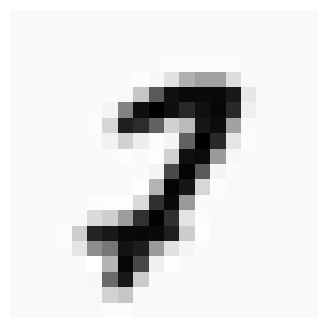

In [36]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Previsão da Rede Neural: {}'.format(*pred))
else:
    print('Não possuímos mais imagens para mostrar')